In [94]:
import numpy as np
import gym
import math
import random
from collections import namedtuple
from itertools import count
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [95]:
env = gym.make('CartPole-v1')

In [96]:
MEMORY_SIZE = 100 * 1000
PRIORITY_EPS = 0.005
PRIORITY_ALPHA = 1

IS_BETA_START = 0.1
IS_BETA_END = 1
IS_BETA_DECAY = 200

In [97]:
class RangeTree:
    def __init__(self):
        self.size = 1
        while self.size < MEMORY_SIZE:
            self.size *= 2
        self.values = np.zeros(2 * self.size)
        self.max_values = np.zeros(2 * self.size)
    
    def add(self, pos, x):
        pos += self.size
        self.values[pos] = x
        self.max_values[pos] = x;
        pos //= 2
        while (pos):
            self.values[pos] = self.values[2 * pos] + self.values[2 * pos + 1]
            self.max_values[pos] = max(self.max_values[2 * pos], self.max_values[2 * pos + 1])
            pos //= 2
            
    def get_max(self):
        return self.max_values[1]
            
    def get(self, x):
        x *= self.values[1]
        pos = 1
        while pos < self.size:
            if x > self.values[2 * pos]:
                x -= self.values[2 * pos]
                pos = pos * 2 + 1
            else:
                pos = pos * 2
        return pos - self.size

In [98]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
        self.tree = RangeTree()
        self.priorities = np.empty((MEMORY_SIZE, ))
        self.size = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
            
        self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max(self.tree.get_max(), PRIORITY_EPS)
        self.tree.add(self.position, self.priorities[self.position] ** PRIORITY_ALPHA)
        
        self.position += 1
        if self.position == self.capacity:
            self.position = 0
            
    def get_priorities(self, positions):
        return [self.priorities[pos] for pos in positions]
    
    def get_transitions(self, positions):
        return [self.memory[pos] for pos in positions]
            
    def update(self, positions, td_errors):
        for (pos, error) in zip(positions, td_errors):
            self.priorities[pos] = abs(error + PRIORITY_EPS)
            self.tree.add(pos,  self.priorities[pos] ** PRIORITY_ALPHA)
            
    def sample(self, batch_size):
        return [self.tree.get(np.random.uniform(k / batch_size, (k + 1) / batch_size)) for k in range(batch_size)]

    def __len__(self):
        return len(self.memory)
        

In [99]:
class DQN(nn.Module):

    def __init__(self, outputs):
        super(DQN, self).__init__()              
        self.first = nn.Linear(4, 320)
        self.output = nn.Linear(320, outputs)

    def forward(self, x):
        x = F.relu(self.first(x))
        x = self.output(x)
        return x

In [100]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [101]:
n_actions = env.action_space.n
steps_done = 0
episode_durations = list()

net = DQN(n_actions)
target_net = DQN(n_actions)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
memory = ReplayMemory(MEMORY_SIZE)

In [102]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [103]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [104]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    transitions_pos = memory.sample(BATCH_SIZE)
    transitions = memory.get_transitions(transitions_pos)
    
    beta = IS_BETA_END - (IS_BETA_END - IS_BETA_START) ** math.exp(-1. * steps_done / IS_BETA_DECAY)
    weights = (torch.FloatTensor(memory.get_priorities(transitions_pos)) * BATCH_SIZE) ** (-beta)
    weights = weights / torch.max(weights)

    batch = Transition(*zip(*transitions))
    
    batch_state = Variable(torch.cat(batch.state))
    batch_action = Variable(torch.cat(batch.action))
    batch_reward = Variable(torch.cat(batch.reward))
    batch_next_state = Variable(torch.cat(batch.next_state))

    state_action_values = net(batch_state).gather(1, batch_action)
    
    next_values = target_net(batch_next_state).max(1)[0].detach()
    expected_state_action_values = (next_values * GAMMA) + batch_reward

    td_error = expected_state_action_values.unsqueeze(1) - state_action_values
    memory.update(transitions_pos, td_error)
    
    loss = F.smooth_l1_loss(state_action_values * weights, expected_state_action_values.unsqueeze(1) * weights)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Complete epoch 0 101.065
Complete epoch 1 142.75
Complete epoch 2 115.87
Complete epoch 3 262.2
Complete epoch 4 500.0
Complete epoch 5 500.0


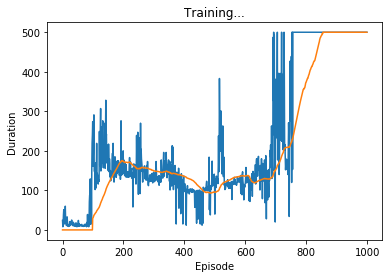

In [105]:
num_episodes = [200] * 5 + [0]
for epoch in range(len(num_episodes)):
    for i_episode in range(num_episodes[epoch]):
        state = torch.FloatTensor([env.reset()])
        for t in count():
            action = select_action(state)
            if epoch == len(num_episodes) - 1:
                env.render()
            next_state, reward, done, _ = env.step(action.item())
            next_state = torch.FloatTensor([next_state])
            if done and t + 1 != 500:
                reward = -1
            reward = torch.FloatTensor([reward])

            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()

            if done:
                episode_durations.append(t + 1)
                break
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(net.state_dict())

    print('Complete epoch {}'.format(epoch), np.mean(episode_durations[-200:]))
    
env.close()
plot_durations()
plt.show()